# Lab 3: Sentiment Analysis with LSTMs using Keras

In this lab session, you'll implement an **RNN-based sentence classifier**. Plain old RNNs aren't very good at sentiment classification, so we will use Keras to implement a more advanced __Long Short Term Memory__ (LSTM) based sentiment classifier.


__Objectives__: In this lab session will learn the following:

- Word embedding representation
- Preprocessing data for recurrent archictures (sequence padding)
- Implementation of LSTM-based classifier



----

Remenber from the theory that Recurrent Neural Networks apply over and over the same function (the recursive cell) to every token in the sequence. In a simplified version the next token is combined with the output of the previous _state_ (contains the information of what has been seen so far) into the recursive function, so that the whole sequence is represented in a single vector.

Figure below shows an unrolled LSTM archicture, in which input text sequence, once tokenized and obtained the word index, is represented by word embeddings. Emebdding lookup layer takes a list of word indexes and returns a list word embeddings (low-dimensional dense vectors that represent words). These word embeddings are what actually fed to sentence encoder. Finally, the last output of the LSTM is fed to a fully connected Dense layer. As we'll learn, this is fairly easy to code with Keras.


![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/LSTM_sentiment.png)


Advantages of these types of architectures:

- We do not need to show the whole sequence to the model. Actually, each input token is processed independently and current state is kept in memory for the next step.
- We save memory as we share the weights for each time-step.

## 1. Loading the data
We'll use the same data used in previous session.

In [1]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install libraries
!pip install tensorflow
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
## for replicability of results
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.utils.set_random_seed(2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [3]:
from sklearn.utils import shuffle

# custom data loader path CHANGE home TO YOUR DIRECTORY
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label


print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Preprocessing: Tokenization, Sequence Padding

When process data to feed a recurrent archicture, we need to do it differently compared to what we have seen so far. Unrolling each sequence one by one would take for ever, as we would lost the hability for parallelization. In deep learning framework learning is done by mini-batching the training data, which requires having same sequence length for all the input examples in the mini-batch.

In order to do mini-batch (there are more sophisticated alternatives):
- Choose a single unrolling constant N (e.g. max sequence length)
- Pad last words with zeros (shifting left)


There are more sophisticated alternivative like shuffling examples by sentence length (set N to max. length in mini-batch).

In the following chunk of code, we will use Keras built-in functions for tokenization and padding sequence.


In [4]:
from tensorflow.keras import preprocessing

max_words = 10000
max_seq = 40

# Create a tokenize that takes the 10000 most common words
tokenizer = preprocessing.text.Tokenizer(num_words=max_words, oov_token='<unk>') # We add the <unk> token for the words Out Of Vocabulary, otherwise masking will give us an error.

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Get data as a lists of integers
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding data: Turn the lists of integers into a 2D integer tensor of shape `(samples, max_seq)`
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_seq, padding='post')
x_dev = preprocessing.sequence.pad_sequences(dev_sequences, maxlen=max_seq, padding='post')
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq, padding='post')

y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Shape of the training set (nb_examples, vector_size): {}'.format(x_train.shape))
print('Shape of the validation set (nb_examples, vector_size): {}'.format(x_dev.shape))
print('Shape of the test set (nb_examples, vector_size): {}'.format(x_test.shape))

# Print some examples
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[0], x_train[0]))
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[1], x_train[1]))

Found 13840 unique tokens.
Shape of the training set (nb_examples, vector_size): (6920, 40)
Shape of the validation set (nb_examples, vector_size): (872, 40)
Shape of the test set (nb_examples, vector_size): (1821, 40)

TEXT: This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .
PADDED: [1831    6 7199   28  937    3 1832 4936  250    5 1200 2984 1201   19
   20 2985 4937   19   18 7200    6  876  537   21 1012   21  208   23
  201   80   11   17  281    4  341    7    5 1317    2  271]

TEXT: Takes a clunky TV-movie approach to detailing a chapter in the life of the celebrated Irish playwright , poet and drinker .
PADDED: [ 235    3 3715  383   16  765    6 4938    3 7201   11    2   81    5
    2 4939 2488 7202 4940    4 7203    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

## 3. First LSTM-based classifier

In this section we will build our first LSTM-based classifier in Keras. Note that the LSTM layer, like the rest of layers in Keras, takes inputs of shape ```[batch_size, sequence_length, input_features]```, and it is the reason of why we perform padding when preprocessed the data in the previous section.

Note that after the padding our data still is 2D tensor of shape ```[batch_size, sequence_length]```. Transformation from 2D to 3D is done with ```Embedding``` layer in Keras, which takes the 2D tensor (```[batch_size, sequence_length]```). ```sequence_length``` is an entry of a list of word indexes, where all the entries in the bacth have the same length. (That's why we padded with zeros the shorter sequences).

```Embedding``` layer return a tensor of shape ```[batch_size, sequence_length, embedding_size]```. This can be understood like adding the corresponding embedded vector to each word in the sequence. The layer can be initialized at radom and learn with backpropagation, or use precomputed embedding vector like _Word2vec_ or _Glove_.

Once our data is represented with 3D tensors we can use directly the ```LSTM``` layer. For this task we will combine three Keras layers in this specific order:

- ```Embedding``` layer: it will transfor the data from 2D to 3D by addig associated embeddings to words in the sequences. In the constructor we need to specify two arguments:
   - input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
   - output_dim: int >= 0. Dimension of the dense embedding.
   
- ```LSTM``` layer: It will encode the input sequnces and return output tensor. For the LSTM we need to specify the number of units of the LSTM:
   - units: Positive integer, dimensionality of the output space.
   
- ```Dense```: It will take the output of the LSTM as input and perform the classification.

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_words = 10000
embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 40, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (128, 128)             │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
tf.keras.utils.set_random_seed(2)
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/20
55/55 - 19s - 345ms/step - accuracy: 0.6461 - loss: 0.6246 - val_accuracy: 0.7764 - val_loss: 0.4995
Epoch 2/20
55/55 - 10s - 173ms/step - accuracy: 0.8697 - loss: 0.3283 - val_accuracy: 0.7775 - val_loss: 0.4902
Epoch 3/20
55/55 - 8s - 139ms/step - accuracy: 0.9392 - loss: 0.1678 - val_accuracy: 0.7683 - val_loss: 0.5400
Epoch 4/20
55/55 - 9s - 170ms/step - accuracy: 0.9519 - loss: 0.1499 - val_accuracy: 0.7878 - val_loss: 0.7801
Epoch 5/20
55/55 - 9s - 171ms/step - accuracy: 0.9676 - loss: 0.1062 - val_accuracy: 0.7752 - val_loss: 0.8337
Epoch 6/20
55/55 - 9s - 155ms/step - accuracy: 0.9835 - loss: 0.0557 - val_accuracy: 0.7787 - val_loss: 0.8158
Epoch 7/20
55/55 - 11s - 201ms/step - accuracy: 0.9922 - loss: 0.0291 - val_accuracy: 0.7867 - val_loss: 0.8988
Epoch 8/20
55/55 - 9s - 171ms/step - accuracy: 0.9947 - loss: 0.0199 - val_accuracy: 0.7810 - val_loss: 1.0276
Epoch 9/20
55/55 - 9s - 159ms/step - accuracy: 0.9981 - loss: 0.0115 - val_accuracy: 0.7672 - val_loss: 1.107

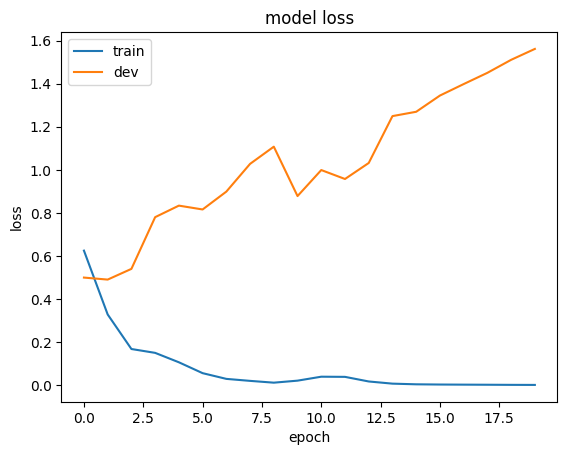

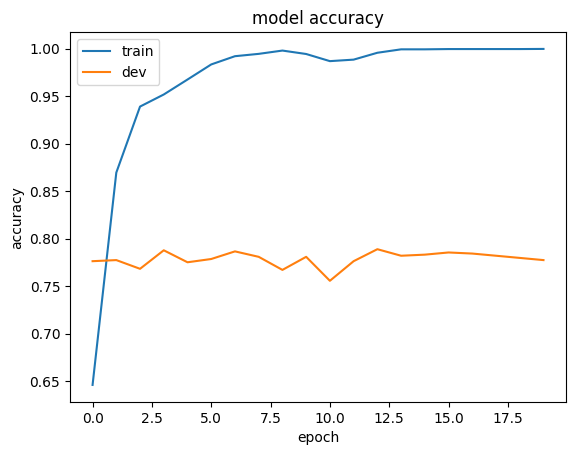

57/57 - 1s - 19ms/step - accuracy: 0.7672 - loss: 1.6400
Accuracy:  0.7671608924865723


In [7]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: ", score[1])

Let's early stop the training

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

early_stop = EarlyStopping(monitor='val_accuracy', patience=0)
history_early_stop = model.fit(x_train, y_train, epochs=20, batch_size=128,
                    validation_data=(x_dev, y_dev),
                    callbacks=[early_stop],
                    verbose=2)

score = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: ", score[1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (128, 40, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (128, 128)             │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 - 12s - 227ms/step - accuracy: 0.6461 - loss: 0.6246 - val_accuracy: 0.7764 - val_loss: 0.4995
Epoch 2/20
55/55 - 8s - 139ms/step - accuracy: 0.8697 - loss: 0.3283 - val_accuracy: 0.7775 - val_loss: 0.4902
Epoch 3/20
55/55 - 9s - 169ms/step - accuracy: 0.9392 - loss: 0.1678 - val_accuracy: 0.7683 - val_loss: 0.5400
57/57 - 1s - 19ms/step - accuracy: 0.8023 - loss: 0.4909
Accuracy:  0.8023064136505127


### Exercise 1

- Try different embedding sizes and number of LSTM units. Do you see any differences in loss and accuracy curves? What happens very small embedding size (e.g ```embedding_size = 8```) or LSTM units (e.g ```units = 16```)? And what happens when we do the opposite thing?

- __Hint:__ Plotting original model's loss curve and your choice's curve will help you analysing the differences.

- __Hint__: Experiments take longer than in the previous labs (model complexity has increase, as well as the vocabulary size), you can increase ```batch_size``` in order to speed up the experiments.

__Answer__: Having large amount of training data with LSTM models (deep learning models in general) tend to improve results using bigger sizes. However, it is also a good regularization to reduce model size.


In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 8
lstm_hidden_size = 128

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

small_emb_history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (128, 40, 8)           │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (128, 128)             │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,273 (587.00 KB)

 Trainable params: 150,273 (587.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 - 10s - 173ms/step - accuracy: 0.5533 - loss: 0.6843 - val_accuracy: 0.6353 - val_loss: 0.6493
Epoch 2/20
55/55 - 8s - 147ms/step - accuracy: 0.7828 - loss: 0.5190 - val_accuracy: 0.7913 - val_loss: 0.4855
Epoch 3/20
55/55 - 7s - 125ms/step - accuracy: 0.8825 - loss: 0.3267 - val_accuracy: 0.7741 - val_loss: 0.4982
Epoch 4/20
55/55 - 5s - 92ms/step - accuracy: 0.9218 - loss: 0.2263 - val_accuracy: 0.7752 - val_loss: 0.5759
Epoch 5/20
55/55 - 7s - 125ms/step - accuracy: 0.9289 - loss: 0.1978 - val_accuracy: 0.7764 - val_loss: 0.6312
Epoch 6/20
55/55 - 9s - 156ms/step - accuracy: 0.9603 - loss: 0.1325 - val_accuracy: 0.7764 - val_loss: 0.6289
Epoch 7/20
55/55 - 7s - 125ms/step - accuracy: 0.9728 - loss: 0.0869 - val_accuracy: 0.7787 - val_loss: 0.7798
Epoch 8/20
55/55 - 5s - 92ms/step - accuracy: 0.9779 - loss: 0.0707 - val_accuracy: 0.7798 - val_loss: 0.9409
Epoch 9/20
55/55 - 6s - 118ms/step - accuracy: 0.9818 - loss: 0.0620 - val_accuracy: 0.7661 - val_loss: 0.8658
Ep

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 128
lstm_hidden_size = 16

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

small_units_history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (128, 40, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (128, 16)              │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (128, 1)               │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,297 (4.92 MB)

 Trainable params: 1,289,297 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 - 5s - 89ms/step - accuracy: 0.6162 - loss: 0.6539 - val_accuracy: 0.7592 - val_loss: 0.5495
Epoch 2/20
55/55 - 2s - 40ms/step - accuracy: 0.8499 - loss: 0.4079 - val_accuracy: 0.7959 - val_loss: 0.4651
Epoch 3/20
55/55 - 3s - 57ms/step - accuracy: 0.9257 - loss: 0.2271 - val_accuracy: 0.7901 - val_loss: 0.5364
Epoch 4/20
55/55 - 4s - 75ms/step - accuracy: 0.9591 - loss: 0.1402 - val_accuracy: 0.7810 - val_loss: 0.6361
Epoch 5/20
55/55 - 2s - 39ms/step - accuracy: 0.9717 - loss: 0.1045 - val_accuracy: 0.7844 - val_loss: 0.6572
Epoch 6/20
55/55 - 2s - 39ms/step - accuracy: 0.9704 - loss: 0.0985 - val_accuracy: 0.7798 - val_loss: 0.6590
Epoch 7/20
55/55 - 3s - 49ms/step - accuracy: 0.9605 - loss: 0.1204 - val_accuracy: 0.7718 - val_loss: 0.6334
Epoch 8/20
55/55 - 3s - 64ms/step - accuracy: 0.9766 - loss: 0.0759 - val_accuracy: 0.7672 - val_loss: 0.7406
Epoch 9/20
55/55 - 2s - 39ms/step - accuracy: 0.9922 - loss: 0.0374 - val_accuracy: 0.7867 - val_loss: 0.7579
Epoch 10/2

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 512
lstm_hidden_size = 128

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

big_emb_history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (128, 40, 512)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (128, 128)             │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,448,321 (20.78 MB)

 Trainable params: 5,448,321 (20.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 - 22s - 404ms/step - accuracy: 0.6845 - loss: 0.5823 - val_accuracy: 0.7718 - val_loss: 0.4854
Epoch 2/20
55/55 - 18s - 330ms/step - accuracy: 0.8938 - loss: 0.2706 - val_accuracy: 0.7603 - val_loss: 0.5409
Epoch 3/20
55/55 - 18s - 323ms/step - accuracy: 0.9490 - loss: 0.1422 - val_accuracy: 0.7810 - val_loss: 0.6478
Epoch 4/20
55/55 - 22s - 404ms/step - accuracy: 0.9738 - loss: 0.0835 - val_accuracy: 0.7752 - val_loss: 0.9128
Epoch 5/20
55/55 - 18s - 326ms/step - accuracy: 0.9754 - loss: 0.0715 - val_accuracy: 0.7775 - val_loss: 0.9378
Epoch 6/20
55/55 - 18s - 324ms/step - accuracy: 0.9867 - loss: 0.0407 - val_accuracy: 0.7706 - val_loss: 1.0921
Epoch 7/20
55/55 - 21s - 387ms/step - accuracy: 0.9851 - loss: 0.0455 - val_accuracy: 0.7592 - val_loss: 0.8323
Epoch 8/20
55/55 - 18s - 324ms/step - accuracy: 0.9860 - loss: 0.0398 - val_accuracy: 0.7592 - val_loss: 0.9153
Epoch 9/20
55/55 - 22s - 401ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.7683 - val_loss:

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 128
lstm_hidden_size = 512

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

big_units_history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (128, 40, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (128, 512)             │     1,312,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (128, 1)               │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,281 (9.89 MB)

 Trainable params: 2,593,281 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 - 68s - 1s/step - accuracy: 0.6406 - loss: 0.6435 - val_accuracy: 0.7649 - val_loss: 0.5371
Epoch 2/20
55/55 - 81s - 1s/step - accuracy: 0.8624 - loss: 0.3457 - val_accuracy: 0.7752 - val_loss: 0.4788
Epoch 3/20
55/55 - 82s - 1s/step - accuracy: 0.9266 - loss: 0.2028 - val_accuracy: 0.7489 - val_loss: 0.5354
Epoch 4/20
55/55 - 84s - 2s/step - accuracy: 0.9601 - loss: 0.1179 - val_accuracy: 0.7706 - val_loss: 0.6565
Epoch 5/20
55/55 - 82s - 1s/step - accuracy: 0.9733 - loss: 0.0826 - val_accuracy: 0.7775 - val_loss: 0.7249
Epoch 6/20
55/55 - 82s - 1s/step - accuracy: 0.9692 - loss: 0.0965 - val_accuracy: 0.7752 - val_loss: 0.6856
Epoch 7/20
55/55 - 64s - 1s/step - accuracy: 0.9832 - loss: 0.0542 - val_accuracy: 0.7557 - val_loss: 1.0380
Epoch 8/20
55/55 - 66s - 1s/step - accuracy: 0.9809 - loss: 0.0581 - val_accuracy: 0.7672 - val_loss: 0.8322
Epoch 9/20
55/55 - 65s - 1s/step - accuracy: 0.9910 - loss: 0.0310 - val_accuracy: 0.7775 - val_loss: 1.1906
Epoch 10/20
55/55 -

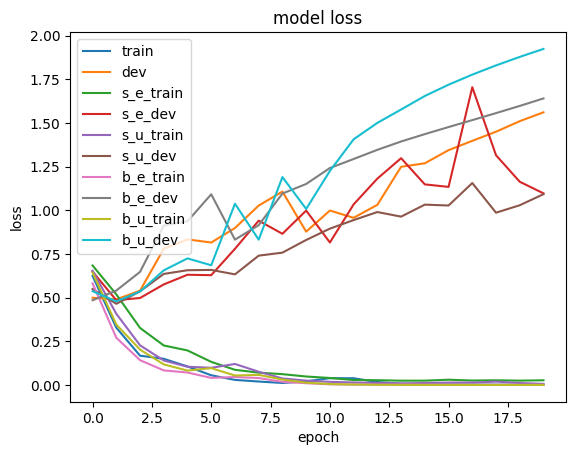

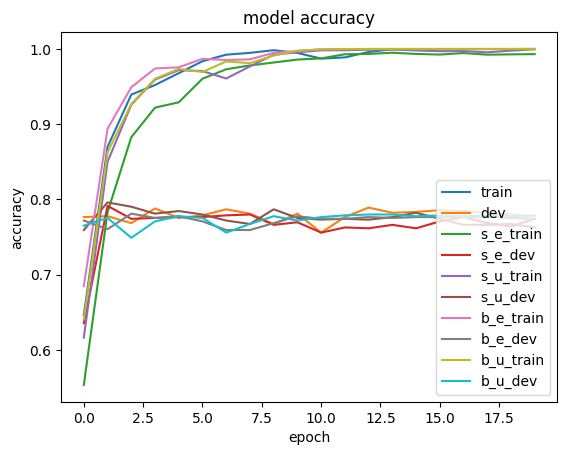

In [13]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.plot(small_emb_history.history['loss'])
plt.plot(small_emb_history.history['val_loss'])

plt.plot(small_units_history.history['loss'])
plt.plot(small_units_history.history['val_loss'])

plt.plot(big_emb_history.history['loss'])
plt.plot(big_emb_history.history['val_loss'])

plt.plot(big_units_history.history['loss'])
plt.plot(big_units_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev', 's_e_train', 's_e_dev', 's_u_train', 's_u_dev', 'b_e_train', 'b_e_dev', 'b_u_train', 'b_u_dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(small_emb_history.history['accuracy'])
plt.plot(small_emb_history.history['val_accuracy'])

plt.plot(small_units_history.history['accuracy'])
plt.plot(small_units_history.history['val_accuracy'])

plt.plot(big_emb_history.history['accuracy'])
plt.plot(big_emb_history.history['val_accuracy'])

plt.plot(big_units_history.history['accuracy'])
plt.plot(big_units_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev', 's_e_train', 's_e_dev', 's_u_train', 's_u_dev', 'b_e_train', 'b_e_dev', 'b_u_train', 'b_u_dev'], loc='lower right')
plt.show()

Since our training set is small and we are using more complex layers, the model is overfitting. But here you have some insights:

**1. Number of Units**
- **More units (neurons)** → higher capacity to capture complex patterns in the data, but risk of overfitting.  
- **Fewer units** → can help to regularize, but may underfit complex data.  
- **Consideration:** The optimal number depends on the complexity of the task and the amount of training data available.

**2. Embedding Dimension**
- **Higher embedding dimensions** → can capture more semantic or structural information, but may overfit to training data.  
- **Lower embedding dimensions** → may generalize better, but can compress too much information, losing important details.  
- **Consideration:** The embedding dimension should balance expressiveness with the risk of overfitting.

**3. Scenarios and Trade-offs**

| Scenario                     | Pros                          | Cons                                  |
|-------------------------------|-------------------------------|--------------------------------------|
| Small units + small embeddings | Efficient, less overfitting; lower computational cost | May underfit complex patterns; limited expressiveness |
| Large units + small embeddings | Can learn complex patterns if data is simple | Limited input information; risk of overfitting wasted capacity |
| Small units + large embeddings | Can represent rich input features | Bottleneck due to insufficient processing capacity; may underutilize embeddings |
| Large units + large embeddings | Powerful, expressive; can capture complex patterns | Risk of overfitting; higher computational cost; slower training |

**4. Key Takeaways**
- The **number of units** determines the network’s capacity to process and transform information.  
- The **embedding dimension** determines how richly each entity is represented.  
- Balance is crucial: too small in either dimension leads to underfitting, too large can lead to overfitting and inefficiency.




### Exercise 2

- It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. How would you do it?

- __Hint:__ You have to get all intermediate layers to return full sequences. Recurrent layers in Keras run in two modes that return different type of tensors:
  - The first one returns the last output of each input sequence $\rightarrow$ ```[batch_size, output_features]```
  - The second one returns the full sequence of successive output for each time-step $\rightarrow$ ```[batch_size, sequence_length, output_features]```
  
- This two modes are controlled by ```return_sequences``` argument in the layer constructor.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (128, 40, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (128, 40, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (128, 128)             │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,543,297 (5.89 MB)

 Trainable params: 1,543,297 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 - 22s - 402ms/step - accuracy: 0.5214 - loss: 0.6906 - val_accuracy: 0.6307 - val_loss: 0.6831
Epoch 2/10
55/55 - 17s - 302ms/step - accuracy: 0.6503 - loss: 0.6284 - val_accuracy: 0.6376 - val_loss: 0.8098
Epoch 3/10
55/55 - 16s - 300ms/step - accuracy: 0.7999 - loss: 0.4521 - val_accuracy: 0.7661 - val_loss: 0.5910
Epoch 4/10
55/55 - 20s - 372ms/step - accuracy: 0.8744 - loss: 0.3174 - val_accuracy: 0.7764 - val_loss: 0.5594
Epoch 5/10
55/55 - 16s - 300ms/step - accuracy: 0.9158 - loss: 0.2294 - val_accuracy: 0.7775 - val_loss: 0.6122
Epoch 6/10
55/55 - 16s - 300ms/step - accuracy: 0.9357 - loss: 0.1768 - val_accuracy: 0.7741 - val_loss: 0.6610
Epoch 7/10
55/55 - 18s - 328ms/step - accuracy: 0.9536 - loss: 0.1367 - val_accuracy: 0.7741 - val_loss: 0.6366
Epoch 8/10
55/55 - 17s - 303ms/step - accuracy: 0.9603 - loss: 0.1109 - val_accuracy: 0.7821 - val_loss: 0.7406
Epoch 9/10
55/55 - 20s - 371ms/step - accuracy: 0.9785 - loss: 0.0667 - val_accuracy: 0.7741 - val_loss:

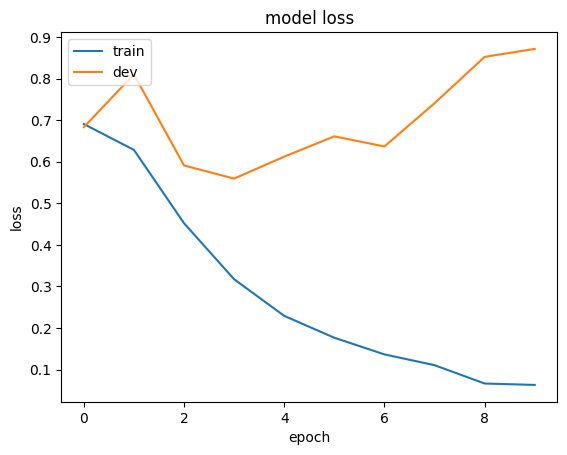

57/57 - 2s - 39ms/step - accuracy: 0.7963 - loss: 0.8443
Accuracy:  0.7962657809257507


In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add the first LSTM layer that return the output of each step in the sequence.
model.add(LSTM(lstm_hidden_size, return_sequences=True))

# 3. Define and add the second LSTM layer that takes output sequence of the first LSTM
model.add(LSTM(lstm_hidden_size))

# 4. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

history_bilstm = model.fit(x_train, y_train, epochs=10, batch_size=128,
                          validation_data=(x_dev, y_dev), verbose=2)

# summarize history for accuracy
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: ", score[1])

## 4. Second LSTM: Initialized with Glove

When the training set is not large enough usually it is a good idea to use precomputed word embeddings as we can add some external knowledge that it is very difficult to acquire from the training set.

### 4.1 Reading precomputed embeddings

In [15]:
def read(file, threshold=0, dim=50, word_index=None):
    max_words = 400000 if threshold <= 0 else min(threshold, 400000)

    embeddings = {}
    lines = file.read()
    file.close()
    lines = lines.decode('utf8')
    for line in lines.split('\n'):
        vec = line.split(' ')
        word = vec[0]
        coefs = np.asarray(vec[1:], dtype='float32')
        embeddings[word] = coefs

    matrix = np.zeros((max_words, dim))
    for word, i in word_index.items():
      embedding_vector = embeddings.get(word)
      if i < max_words:
        if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          matrix[i] = embedding_vector
    return matrix

In [16]:
import bz2

# Read input embeddings
glove_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/data/word-embeddings/'
embsfile = bz2.open(glove_home + 'glove.6B.50d.txt.bz2')
embedding_matrix = read(embsfile, threshold=max_words+1, word_index=word_index)

print(embedding_matrix.shape)

(10001, 50)


### 4.2 Build LSTM based model

We will be using the same architecture as before. Only difference is that now we are going to use an ```embedding_size``` of 50, and the model will be compiled later (after we load the Glove embeddings).

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 50
lstm_hidden_size = 128

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words+1, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (128, 40, 50)          │       500,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (128, 128)             │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,827 (2.26 MB)

 Trainable params: 591,827 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Load precomputed weights

Once we created the embedding matrix (in Section 4.1) in the correct format, we can easily load it into the Embedding layer. Remember that the matrix is of shape ```[max_words, embedding_size]```, where each entry ```i``` contains the embedding vector of the word of index ```i```, created with the tokenizer. Note that the index 0 is not supposed to stand for any word or token.

Embedding layer is the first layer in our model and we can access it with ```model.layers``` list. Once we get it we can initialize the weight as in the code below.

In addition we can freeze the weights so that we avoid updating during training and avoid forgetting what they already know. This is done by setting the attribute ```trainable``` of the layer to ```False```.

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 4.4. Train and evaluate

Training and evaluation is done as in previous models. First we need to compile it (loss, optimizer and evaluation metric are indicated), then fit the model with the training data.

In [19]:
# Compile the model using a loss function and an optimizer.
tf.keras.utils.set_random_seed(2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/10
55/55 - 11s - 201ms/step - accuracy: 0.6522 - loss: 0.6246 - val_accuracy: 0.7156 - val_loss: 0.5915
Epoch 2/10
55/55 - 7s - 128ms/step - accuracy: 0.7168 - loss: 0.5582 - val_accuracy: 0.7317 - val_loss: 0.5436
Epoch 3/10
55/55 - 8s - 138ms/step - accuracy: 0.7377 - loss: 0.5304 - val_accuracy: 0.7489 - val_loss: 0.5169
Epoch 4/10
55/55 - 6s - 115ms/step - accuracy: 0.7475 - loss: 0.5099 - val_accuracy: 0.7477 - val_loss: 0.5041
Epoch 5/10
55/55 - 7s - 136ms/step - accuracy: 0.7627 - loss: 0.4927 - val_accuracy: 0.7454 - val_loss: 0.4955
Epoch 6/10
55/55 - 6s - 103ms/step - accuracy: 0.7715 - loss: 0.4753 - val_accuracy: 0.7603 - val_loss: 0.4907
Epoch 7/10
55/55 - 7s - 127ms/step - accuracy: 0.7832 - loss: 0.4566 - val_accuracy: 0.7695 - val_loss: 0.4859
Epoch 8/10
55/55 - 6s - 110ms/step - accuracy: 0.7905 - loss: 0.4385 - val_accuracy: 0.7661 - val_loss: 0.4879
Epoch 9/10
55/55 - 12s - 211ms/step - accuracy: 0.8038 - loss: 0.4200 - val_accuracy: 0.7741 - val_loss: 0.4981

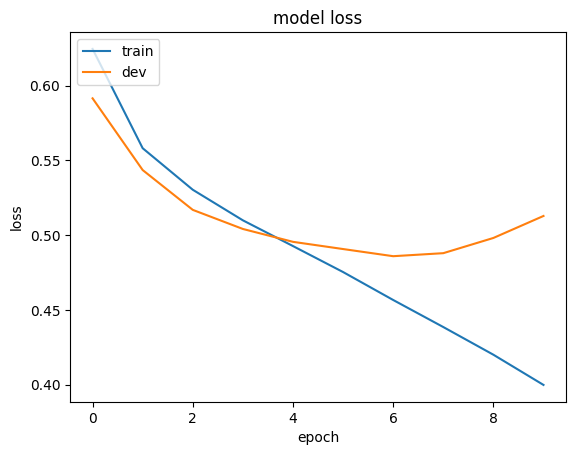

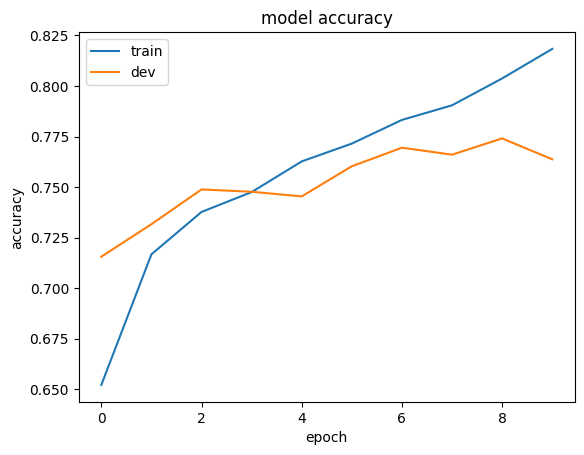

57/57 - 1s - 17ms/step - accuracy: 0.7468 - loss: 0.4947
Accuracy:  0.7468423843383789


In [20]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: ", score[1])

The model does not show any improvements compared to models of the previous section. The reason for that can be  many, for example:
  - Vocabulary size is not big enough so we can expect many unknown word when encoding the sentence (not checked).
  - Maximum sequence length might be too small so we are leaving out some important information (not checked).
  - Training size is not too large, which in those cases simpler model usually perform better (due to the overfitting).

### Exercise 3

- In previous lab session we learn different techniques to avoid overfitting the model. In this case ```Dropout``` seems promising. Try adding a drop-out layer in the LSTM-based model.


### Exercise 4
- Another technique to fight overfitting is to reduce model size. Gated Recurrent Units (```GRU```) are a simpler version of the LSTMs. They have a smaller number of units. Try learning a new model based on GRU layers.

- __Hint__: Check the API for the GRU layer $\rightarrow$ https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU (https://keras.io/layers/recurrent/#gru)
    

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (128, 40, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (128, 16)              │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 16)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (128, 1)               │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,297 (4.92 MB)

 Trainable params: 1,289,297 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 - 6s - 114ms/step - accuracy: 0.5510 - loss: 0.6869 - val_accuracy: 0.6525 - val_loss: 0.6690
Epoch 2/10
55/55 - 5s - 85ms/step - accuracy: 0.6798 - loss: 0.6254 - val_accuracy: 0.7190 - val_loss: 0.5865
Epoch 3/10
55/55 - 3s - 47ms/step - accuracy: 0.7893 - loss: 0.5098 - val_accuracy: 0.7810 - val_loss: 0.5160
Epoch 4/10
55/55 - 3s - 63ms/step - accuracy: 0.8592 - loss: 0.4004 - val_accuracy: 0.7901 - val_loss: 0.4978
Epoch 5/10
55/55 - 2s - 43ms/step - accuracy: 0.8961 - loss: 0.3140 - val_accuracy: 0.7936 - val_loss: 0.5010
Epoch 6/10
55/55 - 2s - 38ms/step - accuracy: 0.9199 - loss: 0.2560 - val_accuracy: 0.7856 - val_loss: 0.5158
Epoch 7/10
55/55 - 2s - 38ms/step - accuracy: 0.9386 - loss: 0.2134 - val_accuracy: 0.7856 - val_loss: 0.5276
Epoch 8/10
55/55 - 3s - 46ms/step - accuracy: 0.9551 - loss: 0.1717 - val_accuracy: 0.7970 - val_loss: 0.5536
Epoch 9/10
55/55 - 3s - 46ms/step - accuracy: 0.9605 - loss: 0.1436 - val_accuracy: 0.7924 - val_loss: 0.5953
Epoch 10/

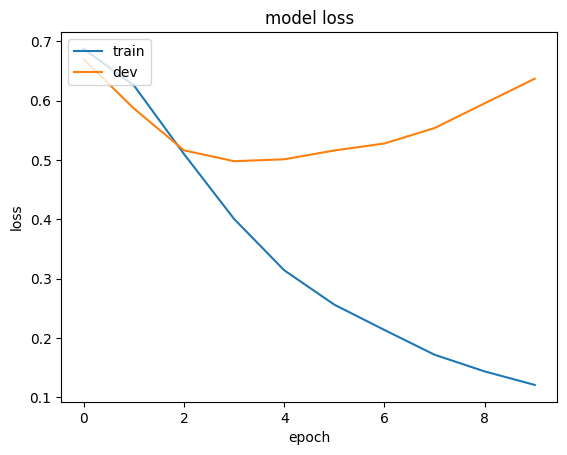

57/57 - 0s - 7ms/step - accuracy: 0.7847 - loss: 0.6078
Accuracy:  0.7847336530685425


In [21]:
# Exercise 3: Add drop-out
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
tf.keras.utils.set_random_seed(2)

max_words = 10000
embedding_size = 128
lstm_hidden_size = 16

model = Sequential()

# 1. Define and add Embedding layer to the model.
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# After the Embedding layer,
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(lstm_hidden_size))

# 3. Add dropout
model.add(Dropout(0.5))

# 4. Define and add Dense layer to the model
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_dropout = model.fit(x_train, y_train, epochs=10, batch_size=128,
                          validation_data=(x_dev, y_dev), verbose=2)

# summarize history for accuracy
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: ", score[1])

## 5. Bidirectional LSTMs

Another well-known archicture is the bidirectional RNN. It is an extension of the regular RNN and usually offers a really good performance. Nowadays it is a standard archictecture in NLP.

Note that RNNs (LSTMs and GRUs in a lesser degree) are dependent of the order and tent to remember the last words they have seen. A solution to this is to read the sentence from left-to-right and right-to-left, which can be implemented with bidirectional LSTMs.


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

max_words = 10000
embedding_size = 50

model = Sequential()
model.add(Embedding(max_words+1, embedding_size, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(128, max_seq)) # pass input size to visualize summary input_shape=(batch_size, max_seq)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (128, 40, 50)          │       500,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (128, 256)             │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (128, 1)               │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,603 (2.61 MB)

 Trainable params: 683,603 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
tf.keras.utils.set_random_seed(2)
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/20
55/55 - 17s - 309ms/step - accuracy: 0.6671 - loss: 0.6085 - val_accuracy: 0.7213 - val_loss: 0.5537
Epoch 2/20
55/55 - 12s - 225ms/step - accuracy: 0.7272 - loss: 0.5377 - val_accuracy: 0.7477 - val_loss: 0.5226
Epoch 3/20
55/55 - 19s - 353ms/step - accuracy: 0.7471 - loss: 0.5103 - val_accuracy: 0.7523 - val_loss: 0.5053
Epoch 4/20
55/55 - 12s - 211ms/step - accuracy: 0.7647 - loss: 0.4872 - val_accuracy: 0.7580 - val_loss: 0.4962
Epoch 5/20
55/55 - 12s - 227ms/step - accuracy: 0.7776 - loss: 0.4642 - val_accuracy: 0.7661 - val_loss: 0.4952
Epoch 6/20
55/55 - 13s - 230ms/step - accuracy: 0.7912 - loss: 0.4428 - val_accuracy: 0.7672 - val_loss: 0.4934
Epoch 7/20
55/55 - 13s - 228ms/step - accuracy: 0.8084 - loss: 0.4168 - val_accuracy: 0.7626 - val_loss: 0.5009
Epoch 8/20
55/55 - 13s - 230ms/step - accuracy: 0.8234 - loss: 0.3892 - val_accuracy: 0.7695 - val_loss: 0.5004
Epoch 9/20
55/55 - 12s - 226ms/step - accuracy: 0.8318 - loss: 0.3679 - val_accuracy: 0.7741 - val_loss:

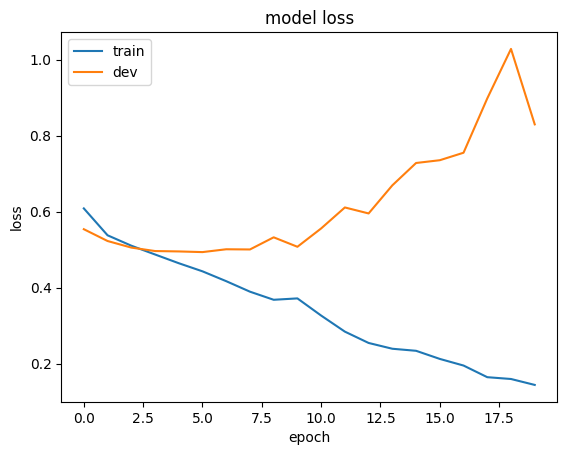

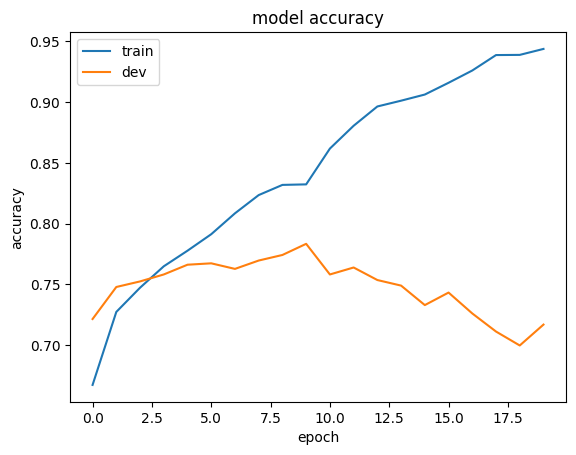

57/57 - 1s - 26ms/step - accuracy: 0.7232 - loss: 0.7880
Accuracy:  0.7232289910316467


In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: ", score[1])

## 6. Improve your model

### Exercise 5
It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning Rates of the optimizer.
- Combination of different regularization techniques.
- Vocabulary size (using larger set of words).
- Number of units in the recurrent layer.
- Number of stacked recurrent layers.
- Type of recurrent layer: LSTM vs GRU vs BiLSTM
- Number of training epochs (if you are using early stopping, set patience).


In [25]:
# preprocess data, take whole vocabulary
from tensorflow.keras import preprocessing

max_seq = 40
# Create a tokenize that takes the whole vocabulary most common words
tokenizer = preprocessing.text.Tokenizer(num_words=None)


# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part
word_index = tokenizer.word_index
max_words = len(word_index)

print('Found %s unique tokens.' % max_words)

# Get data as a lists of integers
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding data: Turn the lists of integers into a 2D integer tensor of shape `(samples, max_seq)`
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_seq, padding="post")
x_dev = preprocessing.sequence.pad_sequences(dev_sequences, maxlen=max_seq, padding="post")
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq, padding="post")

y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Shape of the training set (nb_examples, vector_size): {}'.format(x_train.shape))
print('Shape of the validation set (nb_examples, vector_size): {}'.format(x_dev.shape))
print('Shape of the test set (nb_examples, vector_size): {}'.format(x_test.shape))

# Print some examples
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[0], x_train[0]))
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[1], x_train[1]))


Found 13839 unique tokens.
Shape of the training set (nb_examples, vector_size): (6920, 40)
Shape of the validation set (nb_examples, vector_size): (872, 40)
Shape of the test set (nb_examples, vector_size): (1821, 40)

TEXT: This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .
PADDED: [1830    5 7198   27  936    2 1831 4935  249    4 1199 2983 1200   18
   19 2984 4936   18   17 7199    5  875  536   20 1011   20  207   22
  200   79   10   16  280    3  340    6    4 1316    1  270]

TEXT: Takes a clunky TV-movie approach to detailing a chapter in the life of the celebrated Irish playwright , poet and drinker .
PADDED: [ 234    2 3714  382   15  764    5 4937    2 7200   10    1   80    4
    1 4938 2487 7201 4939    3 7202    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

In [26]:
import bz2

# Read input embeddings
glove_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/data/word-embeddings/'
embsfile = bz2.open(glove_home + 'glove.6B.50d.txt.bz2')
embedding_matrix = read(embsfile, threshold=max_words+1, word_index=word_index)

print(embedding_matrix.shape)

(13840, 50)


In [27]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def get_model(vocab_size, embedding_size, batch_size, reg_weight = 0.0, dr=0.0):
    model = Sequential()

    model.add(Embedding(vocab_size+1, embedding_size, mask_zero=True))
    model.add(Bidirectional(LSTM(128,
                                 kernel_regularizer=regularizers.l2(reg_weight))))
    model.add(Dropout(dr))
    model.add(Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Dropout(dr))
    model.add(Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    model.build(input_shape=(batch_size, max_seq))
    return model

def init_pretrained(model, embedding_matrix, trainable=True):
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = trainable

In [ ]:
import time
tf.keras.utils.set_random_seed(2)
input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.
lrs = [0.0001, 0.001, 0.01]
drs = [0.0, 0.2, 0.5]
regs = [0.0, 0.0001]
pretrained_embeddings = [True, False]
num_epochs = 100
batch_size = 32
embedding_size = 50

early_stop = EarlyStopping(monitor='val_loss', patience=2)

histories = {}
for lr in lrs:
    for reg in regs:
        for dr in drs:
            for use_pretrained_embs in pretrained_embeddings:
                # Define the model
                model = get_model(max_words, embedding_size, batch_size, reg, dr)
                if use_pretrained_embs:
                    init_pretrained(model, embedding_matrix, trainable=True)

                # Compile the model using a loss function and an optimizer.
                model.compile(loss='binary_crossentropy',
                            optimizer=Adam(learning_rate=lr),
                            metrics=['accuracy'])

                print('[{}]: Training model: lr{}-reg{}-dr{}-pe{}'.format(time.asctime(),lr, reg, dr, use_pretrained_embs))

                # Train the model
                histories["lr{}-reg{}-dr{}-pe{}".format(lr, reg, dr, use_pretrained_embs)] = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size,
                                                                            validation_data=(x_dev, y_dev), verbose=2,
                                                                            callbacks=[early_stop])


[Wed Oct  1 15:25:32 2025]: Training model: lr0.0001-reg0.0-dr0.0-peTrue
Epoch 1/100
217/217 - 30s - 140ms/step - accuracy: 0.6379 - loss: 0.6478 - val_accuracy: 0.7099 - val_loss: 0.5729
Epoch 2/100
217/217 - 25s - 113ms/step - accuracy: 0.7279 - loss: 0.5575 - val_accuracy: 0.7339 - val_loss: 0.5334
Epoch 3/100
217/217 - 23s - 108ms/step - accuracy: 0.7529 - loss: 0.5174 - val_accuracy: 0.7477 - val_loss: 0.5139
Epoch 4/100
217/217 - 43s - 196ms/step - accuracy: 0.7704 - loss: 0.4883 - val_accuracy: 0.7466 - val_loss: 0.4988
Epoch 5/100
217/217 - 29s - 135ms/step - accuracy: 0.7867 - loss: 0.4626 - val_accuracy: 0.7534 - val_loss: 0.4870
Epoch 6/100
217/217 - 36s - 165ms/step - accuracy: 0.8032 - loss: 0.4383 - val_accuracy: 0.7695 - val_loss: 0.4786
Epoch 7/100
217/217 - 26s - 118ms/step - accuracy: 0.8178 - loss: 0.4150 - val_accuracy: 0.7741 - val_loss: 0.4732
Epoch 8/100
217/217 - 25s - 115ms/step - accuracy: 0.8298 - loss: 0.3924 - val_accuracy: 0.7810 - val_loss: 0.4708
Epoch 9

In [ ]:
best_epochs = []
accs = []
params_list = []
for params in histories:
    params_list.append(params)
    index = np.argmax(histories[params].history['val_accuracy'])
    best_epochs.append(index+1)
    accs.append(histories[params].history['val_accuracy'][index])
results = pd.DataFrame(data={'params': params_list, 'best_epoch':best_epochs, 'acc':accs})
results.sort_values(by='acc', ascending=False)